In [56]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import ml_utils.utils as ml_utils
import matplotlib.pyplot as plt
import numpy as np
import os

path_data = 'data'
path_train_dir = os.path.join(path_data, 'training')
path_train_label = os.path.join(path_data, 'test_set_images')

PATCH_SIZE = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load data images and split them in to set (train and validation) according to seed and rato. Note that id_xxxx are the variable that store the id of the images to retreive them later.

In [57]:
im_train, lab_train, im_valid, lab_valid, id_train, id_valid = ml_utils.load_train_set(path_train_dir)

Display first image of train set. Left is satellite image and right ground truth (roads)

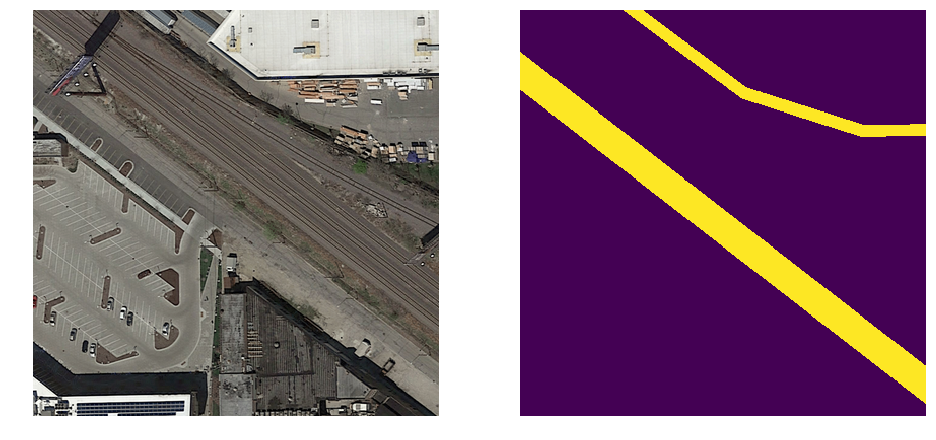

In [58]:
plt.figure(figsize=(16, 8));
plt.subplot(1,2,1); plt.imshow(im_train[0]); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(lab_train[0]); plt.axis("off")
plt.show()

Display histogram for all chanels (RGB). Note that road are more mostly present in interval [0.3, 0.6]. Which make sens since gray is a muxture of all chanels.

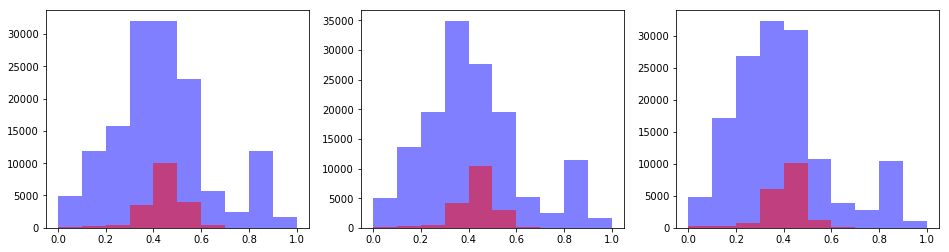

In [59]:
id_road = lab_train[0].flatten()!=0
id_background = lab_train[0].flatten()==0

plt.figure(figsize=(16,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist((im_train[0,:,:,i].flatten())[id_background], color='b', alpha=0.5)
    plt.hist((im_train[0,:,:,i].flatten())[id_road], color='r', alpha=0.5)

Normalize each image according to itself. Center image (mean value) and divide by norm L2.

In [60]:
im_train = ml_utils.normalize_data(im_train)
im_valid = ml_utils.normalize_data(im_valid)

Create patches of predefined sizes. Note that this size is arbitrary. It will be good to test with different settings.

In [61]:
# Convert images to batches (easier for ML task)
x_patches_tr, y_patches_tr, y_patches_lab_tr = ml_utils.get_patches_all(im_train, lab_train, PATCH_SIZE)
x_patches_val, y_patches_val, y_patches_lab_val = ml_utils.get_patches_all(im_valid, lab_valid, PATCH_SIZE)

print('Train:\nx_patches shape: {}, y_patches shape: {}, y_patches_label shape: {}'.format(
    x_patches_tr.shape, y_patches_tr.shape, y_patches_lab_tr.shape))
print('\nValidation:\nx_patches shape: {}, y_patches shape: {}, y_patches_label shape: {}'.format(
    x_patches_val.shape, y_patches_val.shape, y_patches_lab_val.shape))

Train:
x_patches shape: (50000, 16, 16, 3), y_patches shape: (50000, 16, 16), y_patches_label shape: (50000,)

Validation:
x_patches shape: (12500, 16, 16, 3), y_patches shape: (12500, 16, 16), y_patches_label shape: (12500,)


In [62]:
# Do not work beacause normalization, but if removve normalization -> Ok
# offset = 3300 
# plt.figure(figsize=(16, 5))
# for i in range(6):
#    plt.subplot(2, 6,i+1)
#    plt.imshow(x_patches_tr[offset+i]); plt.axis('off')
#    plt.subplot(2, 6, 6+i+1)
#    plt.title('Road: {:1.0f}'.format(y_patches_lab_tr[offset+i]))
#    plt.imshow(y_patches_tr[offset+i], vmin=0, vmax=1); plt.axis('off')

In [63]:
# Do not work beacause normalization, but if removve normalization -> Ok
# offset = 12
# plt.figure(figsize=(16, 5))
# for i in range(6):
#    plt.subplot(2, 6,i+1)
#    plt.imshow(x_patches_val[offset+i]); plt.axis('off')
#    plt.subplot(2, 6, 6+i+1)
#    plt.title('Road: {:1.0f}'.format(y_patches_lab_val[offset+i]))
#    plt.imshow(y_patches_val[offset+i], vmin=0, vmax=1); plt.axis('off')

Create feature set for classification based on mean and stddev value sof each patches.

In [64]:
x_train = ml_utils.create_features(x_patches_tr)
x_valid = ml_utils.create_features(x_patches_val)
y_train = y_patches_lab_tr
y_valid = y_patches_lab_val

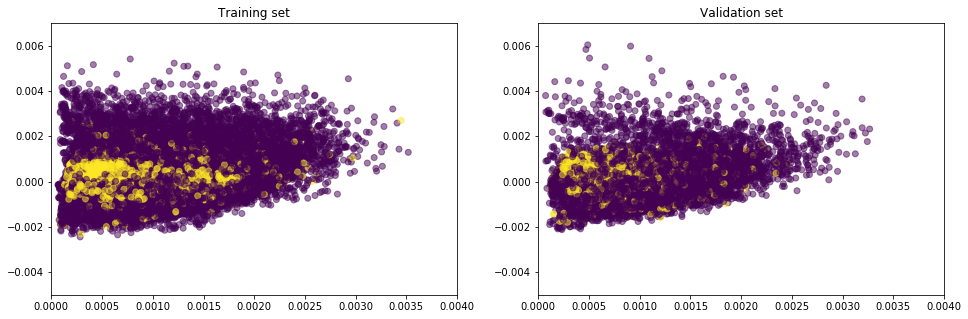

In [65]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.xlim([0, 4e-3]); plt.ylim([-5e-3, 7e-3]); plt.title('Training set')
plt.scatter(x_train[:,6], x_train[:,7], c=y_patches_lab_tr, alpha=0.5)
plt.subplot(1,2,2)
plt.xlim([0, 4e-3]); plt.ylim([-5e-3, 7e-3]); plt.title('Validation set')
plt.scatter(x_valid[:,6], x_valid[:,7], c=y_patches_lab_val, alpha=0.5)

Perform classification using KNN classifier. Majority voting (we can test with others)

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score

# model = LogisticRegression(C=1e5, class_weight="balanced")
# model = GaussianNB()
# model = SVC(kernel="linear")
# model = KNeighborsClassifier(n_neighbors=3)
# model = RandomForestClassifier(max_depth=10, max_features=8, random_state=0)

scores = cross_val_score(model, x_train, y_train, cv=5, scoring='f1_macro')

model.fit(x_train, y_train)
y_pred_tr = model.predict(x_train)
y_pred_va = model.predict(x_valid)

In [69]:
print('f1-score: {:.2f} ± {:.2f}%'.format(100*np.mean(scores), 100*np.std(scores)))
print('Precision Valid: {:.2f}%, recall: {:.2f}%, f1-score: {:.2f}%'.format(
    100*precision_score(y_pred_va, y_valid), 100*recall_score(y_pred_va, y_valid), 
    100*f1_score(y_pred_va, y_valid, average='macro')))

f1-score: 61.19 ± 0.86%
Precision Valid: 60.44%, recall: 35.13%, f1-score: 61.18%


Display prediction results for different images (defined by id_display)

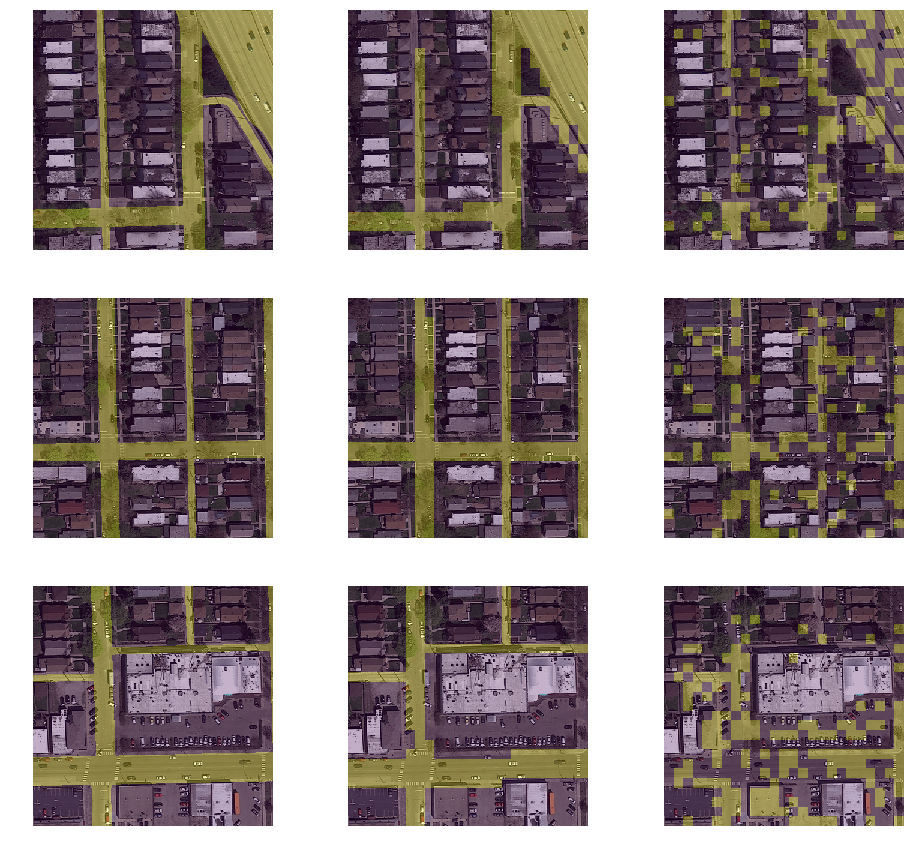

In [41]:
id_display = [0, 5, 15]

plt.figure(figsize=(16, 5*len(id_display)))
for i, id_ in enumerate(id_display):
    # Get source image and predction for current id
    im, cgt = ml_utils.load_image_train_by_id(id_valid[id_], path_train_dir)
    cgt_label = ml_utils.patches_to_img(y_valid[id_*(25*25):(id_+1)*(25*25)], im.shape)
    pred_label = ml_utils.patches_to_img(y_pred_va[id_*(25*25):(id_+1)*(25*25)], im.shape)
    
    plt.subplot(len(id_display),3,i*3+1)
    plt.imshow(im); plt.imshow(cgt, alpha=0.3); plt.axis('off');
    plt.subplot(len(id_display),3,i*3+2)
    plt.imshow(im); plt.imshow(cgt_label, alpha=0.3); plt.axis('off');
    plt.subplot(len(id_display),3,i*3+3)
    plt.imshow(im); plt.imshow(pred_label, alpha=0.3); plt.axis('off');

Use exact same logic as validation and train set. Note that we can display the results to check wheter they are coherent or not.

In [42]:
im_test = ml_utils.load_test_set(path_data)
im_test = ml_utils.normalize_data(im_test)

In [43]:
x_patches_ts, _, _ = ml_utils.get_patches_all(im_test, patch_size=PATCH_SIZE)
x_test = ml_utils.create_features(x_patches_ts)
y_pred = model.predict(x_test)

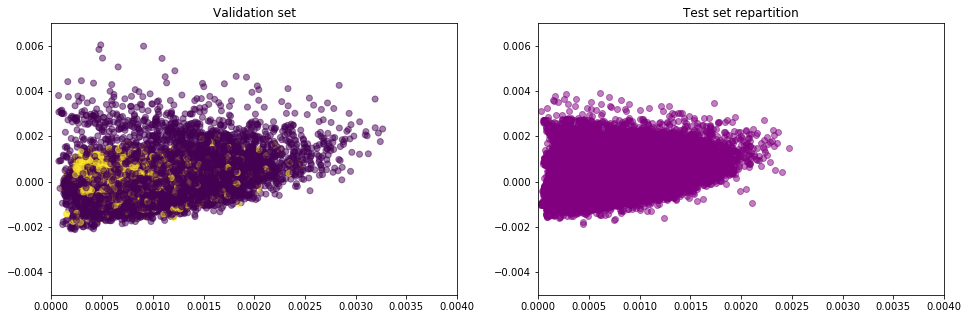

In [44]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.xlim([0, 4e-3]); plt.ylim([-5e-3, 7e-3]); plt.title('Validation set')
plt.scatter(x_valid[:,6], x_valid[:,7], c=y_patches_lab_val, alpha=0.5)
plt.subplot(1,2,2)
plt.xlim([0, 4e-3]); plt.ylim([-5e-3, 7e-3]); plt.title('Test set repartition')
plt.scatter(x_test[:,6], x_test[:,7], c='purple', alpha=0.5)

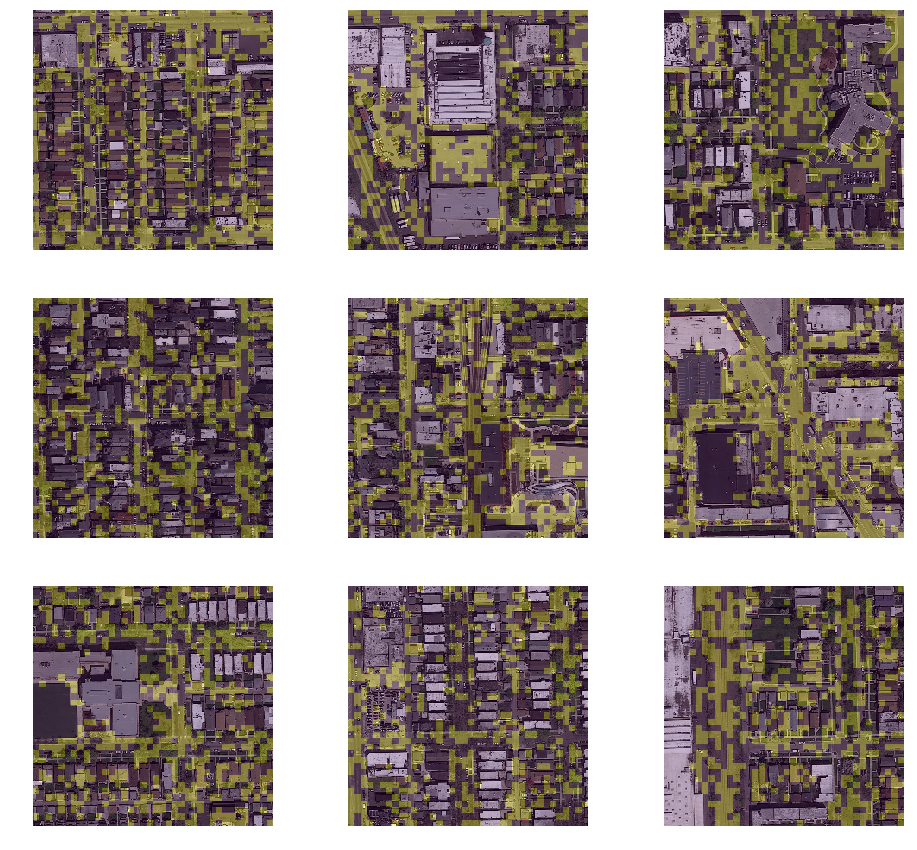

In [45]:
id_display = [0, 1, 2, 20, 21, 22, 40, 41, 42]

plt.figure(figsize=(16, 5*(len(id_display)//3)))
for i, id_ in enumerate(id_display):
    # Get source image and predction for current id
    im = ml_utils.load_image_test_by_id(id_+1, path_data)
    pred_label = ml_utils.patches_to_img(y_pred[id_*(38*38):(id_+1)*(38*38)], im.shape)
    plt.subplot(len(id_display)//3, 3, i+1)
    plt.imshow(im); plt.imshow(pred_label, alpha=0.3); plt.axis('off');

Create submission file for test evaluation

In [46]:
ml_utils.create_submission(y_pred, 'test_submission.csv')

# CNN

In [47]:
from scipy import sparse

def convert_to_one_hot(a, max_val=None):
    """ Convert to one one (eg. [0 0 1] for 2 or [0 1 0] for 1). a is the input vector to convert. max_val is the maximum 
        value of a, which is the number of classes
    """
    N = a.size
    data = np.ones(N,dtype=int)
    sparse_out = sparse.coo_matrix((data,(np.arange(N),a.ravel())), shape=(N,max_val))
    return np.array(sparse_out.todense())

id_back_fair = np.random.permutation(np.nonzero(y_patches_lab_tr == 0)[0])[:9000]
id_road_fair = np.random.permutation(np.nonzero(y_patches_lab_tr == 1)[0])[:9000]
id_fair = np.concatenate((id_back_fair, id_road_fair))
id_fair = np.random.permutation(id_fair)

x_train = x_patches_tr[id_fair]
y_train = convert_to_one_hot(y_patches_lab_tr[id_fair], 2)

In [48]:
batch_size=100
K=8
F=9
d1 = x_train.shape[1]    # data dimensionality
d2 = x_train.shape[2]    # data dimensionality
nc = y_train.shape[1]  # number of classes
ncl = K*K*F
nfc = d1*d2*F

learning_rate=1e-3
reg_par = 1*1e-4

In [49]:
import tensorflow as tf

# CNN inputs variables
xin = tf.placeholder(tf.float32,[batch_size, d1, d2, 3], name='xin'); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc], name='y_label');  #print('y_label=',y_label,y_label.get_shape())

# CNN learning variables
Wcl = tf.Variable(tf.truncated_normal([K,K,3,F], stddev=tf.sqrt(2./tf.to_float(ncl)) ));
bcl = tf.Variable(tf.zeros([F])); 
Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(6./tf.to_float(nfc+nc))));
bfc = tf.Variable(tf.zeros([nc]));

# Layer No 1 --- Convolution
x = tf.nn.conv2d(xin, Wcl, strides=[1, 1, 1, 1], padding='SAME') + bcl;
x = tf.nn.relu(x)

# Layer No 2 --- Fully connected
x = tf.reshape(x, [batch_size,-1]); 
y = tf.matmul(x, Wfc) + bfc; 
y = tf.nn.softmax(y);

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
# L2 Regularization
reg_loss = tf.nn.l2_loss(Wfc) + tf.nn.l2_loss(bfc)
total_loss = cross_entropy + reg_par* reg_loss

# Optimization scheme
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

# Metric outputs
y_pred = tf.argmax(y,1)
y_cgt = tf.argmax(y_label,1)

In [50]:
import collections

n_iter = 10000
n = x_train.shape[0]
indices = collections.deque()
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Keep trace of running process
acc_train_tot = []; acc_valid_tot = []; loss_tot = []

for i in range(n_iter+1):
    # Batch extraction (random permutation)
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = x_train[idx], y_train[idx]
    # Run CNN for variable training (feed dictionnary with batch data, label and dropout)
    y_pred_train, y_cgt_train, loss_train = sess.run([y_pred, y_cgt, total_loss],
                                                     feed_dict={xin: batch_x, y_label: batch_y})

    if i%500 == 0:
        print('Precision Train: {:.3f}, recall: {:.3f}, f1-score: {:.3f}'.format(
            precision_score(y_pred_train, y_cgt_train), recall_score(y_pred_train, y_cgt_train), 
            f1_score(y_pred_train, y_cgt_train, average='macro')))

Precision Train: 0.400, recall: 0.688, f1-score: 0.563
Precision Train: 0.289, recall: 0.481, f1-score: 0.501
Precision Train: 0.323, recall: 0.645, f1-score: 0.467
Precision Train: 0.460, recall: 0.622, f1-score: 0.583
Precision Train: 0.400, recall: 0.571, f1-score: 0.540
Precision Train: 0.412, recall: 0.583, f1-score: 0.542
Precision Train: 0.404, recall: 0.475, f1-score: 0.502


KeyboardInterrupt: 

In [52]:
batch_size=100
K=8
F1=9
F2=9
d1 = x_train.shape[1]    # data dimensionality
d2 = x_train.shape[2]    # data dimensionality
nc = y_train.shape[1]  # number of classes
ncl1 = K*K*F1
ncl2 = K*K*F2
nfc = d1*d2
n_feat1 = 64

learning_rate=1e-3
reg_par = 1*1e-4

# CNN inputs variablncl2es
xin = tf.placeholder(tf.float32,[batch_size, d1, d2, 3], name='xin');
y_label = tf.placeholder(tf.float32,[batch_size,nc], name='y_label');  
d = tf.placeholder(tf.float32, name='d');

# CNN learning variable
Wcl1 = tf.Variable(tf.truncated_normal([K,K,1,F1], stddev=tf.sqrt(2./tf.to_float(ncl1)) ))
bcl1 = tf.Variable(tf.zeros([F1])) 
Wcl2 = tf.Variable(tf.truncated_normal([K,K,F1,F2], stddev=tf.sqrt(2./tf.to_float(ncl2)) ));
bcl2 = tf.Variable(tf.zeros([F2])); 
Wfc = tf.Variable(tf.truncated_normal([(d1*d2//16)*F2, n_feat1], stddev=tf.sqrt(2./tf.to_float(24*24*F2)) ));
bfc = tf.Variable(tf.zeros([n_feat1])); 
Wfc2 = tf.Variable(tf.truncated_normal([n_feat1, nc], stddev=tf.sqrt(2./tf.to_float(n_feat1))));
bfc2 = tf.Variable(tf.zeros([nc]));

# Layer No 1 --- Convolution
x = tf.nn.conv2d(xin, Wcl, strides=[1, 1, 1, 1], padding='SAME') + bcl;
x = tf.nn.relu(x)

# Layer 2 --- Pooling
x = tf.nn.max_pool(value=x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
# print('Pooling : x=',x.get_shape())

# Layer 3 --- Convolution layer 2
x = tf.nn.conv2d(x, Wcl2, strides=[1, 1, 1, 1], padding='SAME') + bcl2;  
x = tf.nn.relu(x)
# print('Convolutional 2 : x=',x.get_shape())

# Layer 4 --- Pooling
x = tf.nn.max_pool(value=x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Layer 5 --- Fully connected
x = tf.reshape(x, [-1, (d1*d2//16)*F2])
x = tf.matmul(x, Wfc) + bfc
x = tf.nn.relu(x)
x = tf.nn.dropout(x, d)

# Layer 6 --- Fully connected 2
y = tf.matmul(x, Wfc2) + bfc2
y = tf.nn.softmax(y)

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
# L2 Regularization
reg_loss = tf.nn.l2_loss(Wfc) + tf.nn.l2_loss(bfc) + tf.nn.l2_loss(Wfc2) + tf.nn.l2_loss(bfc2)
total_loss = cross_entropy + reg_par* reg_loss

# Optimization scheme
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

# Metric outputs
y_pred = tf.argmax(y,1)
y_cgt = tf.argmax(y_label,1)

In [53]:
import collections

n_iter = 10000
n = x_train.shape[0]
indices = collections.deque()
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Keep trace of running process
acc_train_tot = []; acc_valid_tot = []; loss_tot = []

for i in range(n_iter+1):
    # Batch extraction (random permutation)
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = x_train[idx], y_train[idx]
    # Run CNN for variable training (feed dictionnary with batch data, label and dropout)
    y_pred_train, y_cgt_train, loss_train = sess.run([y_pred, y_cgt, total_loss],
                                                     feed_dict={xin: batch_x, y_label: batch_y, d: 0.75})

    if i%500 == 0:
        print('Precision Train: {:.3f}, recall: {:.3f}, f1-score: {:.3f}'.format(
            precision_score(y_pred_train, y_cgt_train), recall_score(y_pred_train, y_cgt_train), 
            f1_score(y_pred_train, y_cgt_train, average='macro')))

Precision Train: 0.562, recall: 0.458, f1-score: 0.467
Precision Train: 0.477, recall: 0.429, f1-score: 0.487
Precision Train: 0.571, recall: 0.519, f1-score: 0.530
Precision Train: 0.550, recall: 0.635, f1-score: 0.533
Precision Train: 0.452, recall: 0.404, f1-score: 0.484


KeyboardInterrupt: 